<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Откроем файл с данными и ознакомимся с ними, открыв первые пять строк и вызвав функцию .info()

In [1]:
#Импортируем необходимые для работы библиотеки:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Откроем файл
data = pd.read_csv('Churn.csv')

#Ознакомимся с данными:
display(data.info())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Изучив данные можно прийти к следующему выводу:
1. в таблице есть колонки, которые очевидно не будут влиять на обучаемость модели (фамилии, уникальный идентификатор клиента)
2. таблица содержит пропуски в столбце о времени обслуживания клиентов в банке. Данный столбец проанализируем отдельно, чтобы понять как поступить с пропущенными значениями. 

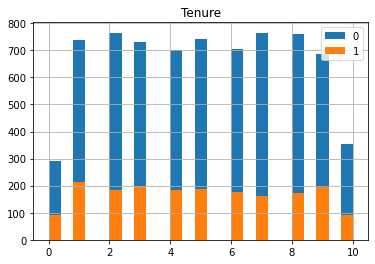

Коэффициент корреляции: -0.016761481514933767


In [2]:
#Выведем на экран гистограмму, 
#которая отражает доли ушедших клиентов из банка в разрезе каждого значения данного столбца.
data_a = data.query('Exited == 1')
data_b = data.query('Exited == 0')
data_b['Tenure'].hist(bins = 25,label = '0')
data_a['Tenure'].hist(bins = 25,label = '1')
plt.legend()
plt.title('Tenure')
plt.show()

#Посчитаем коэффициент корреляции:
print('Коэффициент корреляции:', data['Tenure'].corr(data['Exited']))


Судя по данным, значения доли ушедших клиентов примерно одинаково в разрезе каждого значения срока обслуживания. Таким образом можно сделать вывод о том, что данный показатель не является значимым, и его можно не брать во внимание при обучении модели.
Данное предположение мы подтвердили, посчитав коэффициент корреляции, который оказался близким к 0.

Уберем лишние столбцы:

In [3]:
data = data.drop(['Surname','Tenure','CustomerId','RowNumber'],axis=1)

В оставшихся ячейках изучим корреляции в данных. Так мы можем оценить взаимосвязи в данных и влияние параметров на целевой признак. Воспользуемся для этого методом `sns.pairplot` с параметром hue, в который мы передаем целевой признак.


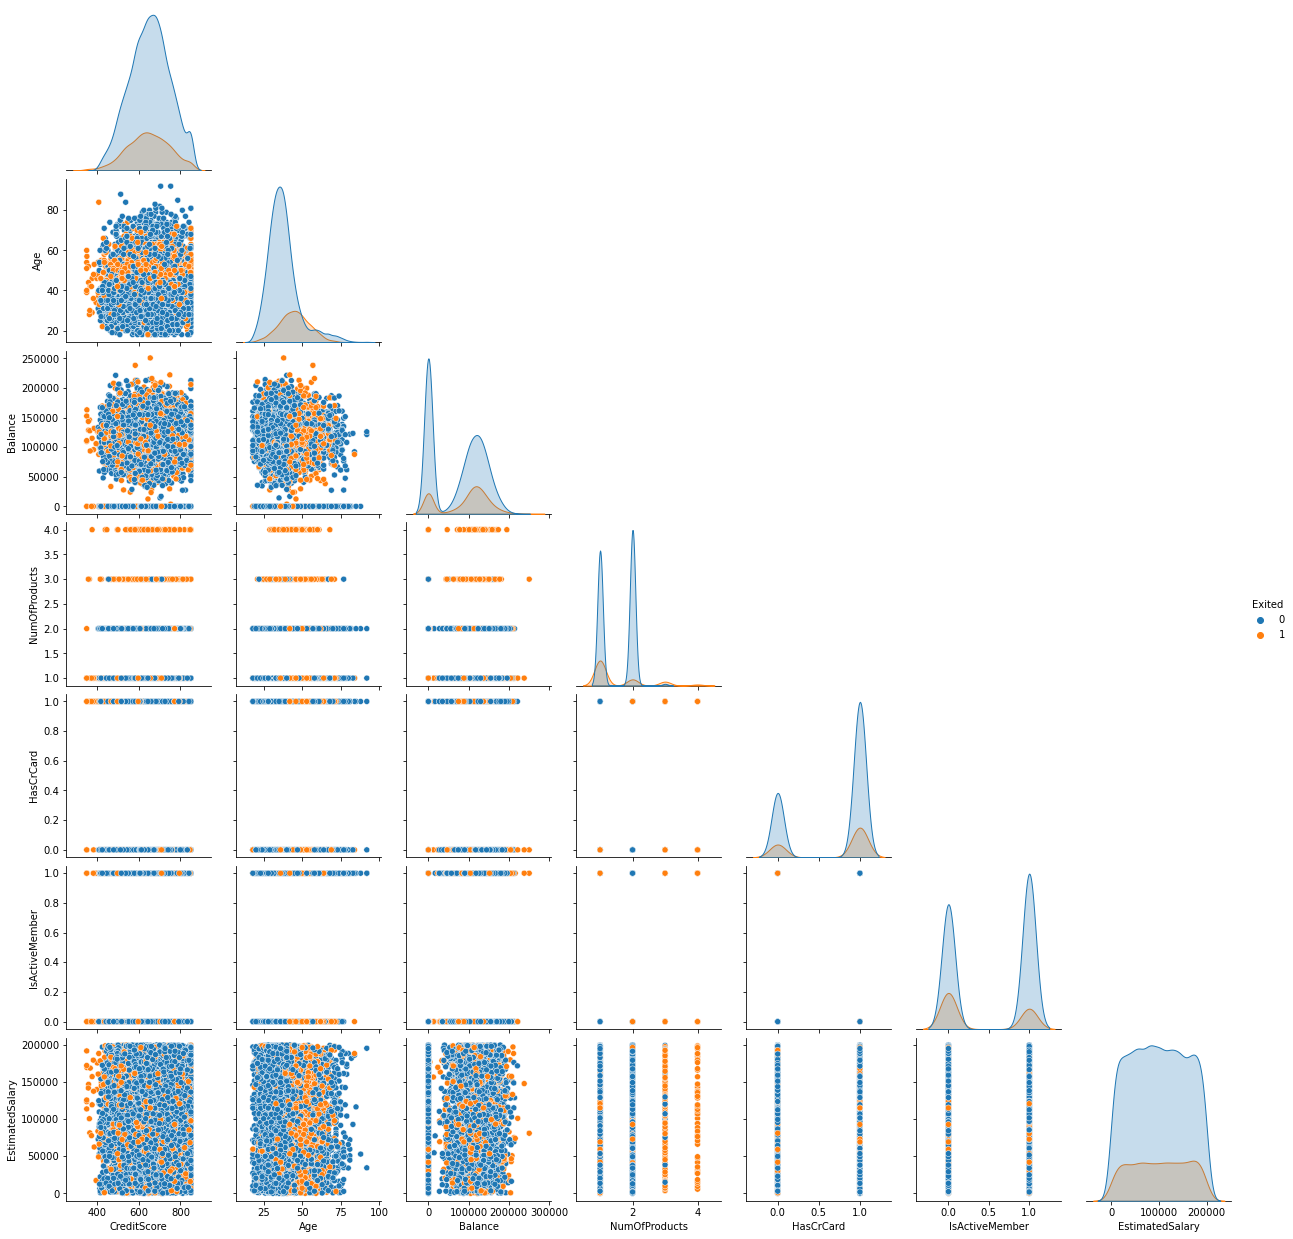

In [4]:
sns.pairplot(data,hue = 'Exited',corner=True)

На графике видны определенные закономерности в признаках - среди ушедших больше людей среднего возраста (от 40 до 60 лет) с количеством продуктов более 2 и невысоким кредитным рейтингом

Преобразуем категориальные признаки в численные с помощью техники One-Hot Encoding, а для избежания дамми-ловушки, применим аругмент drop_first и удалим лишние столбцы.

In [5]:
data_ohe = pd.get_dummies(data, drop_first=True)

## Исследование задачи

Мы преобразовали данные для дальнейшего анализа и обучения модели. Теперь разобьем нашу выборку на три в пропорции 20\20\60. Так мы получим тестовую, обучающую и валидационную выборки.

In [6]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)
#Выделим тестовую выборку (20% от общих данных)
features_other, features_test, target_other, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)
#Выделим валидационную и обучающую выборки:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_other, target_other, test_size=0.2, random_state=12345)

#Стандартизируем признаки:
numerik = ['CreditScore','Age','Balance','EstimatedSalary','NumOfProducts']
scaler = StandardScaler()
scaler.fit(features_train[numerik]) 
features_train[numerik] = scaler.transform(features_train[numerik])
features_valid[numerik] = scaler.transform(features_valid[numerik])
features_test[numerik] = scaler.transform(features_test[numerik]) 

pd.options.mode.chained_assignment = None 

#Обучим модель на полученных данных:
model = DecisionTreeClassifier(random_state = 12345)
model.fit(features_train,target_train)
predicted_valid_dtc = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid,predicted_valid_dtc)
f1_dtc = f1_score(target_valid,predicted_valid_dtc)
auc_roc_dtc = roc_auc_score(target_valid,predicted_valid_dtc)
print('Значение accuracy - {} | F1 - {:.3f}| auc-roc -{:.3f}'.format(accuracy_valid,f1_dtc,auc_roc_dtc))



Значение accuracy - 0.8 | F1 - 0.472| auc-roc -0.674


<ipython-input-6-c6610cb3da76>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numerik] = scaler.transform(features_train[numerik])
C:\Users\shulp\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-6-c6610cb3da76>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

Построим константную модель и сравним с деревом решений.

In [7]:
target_pred_constant = pd.Series(target*0)
print(accuracy_score(target, target_pred_constant)) 


0.7963


accuracy решающего дерева и константной модели почти одинаковы. В нашей задаче наблюдается сильный дисбаланс классов (англ. class imbalance), что плохо сказывается на обучении модели.

## Борьба с дисбалансом

Создадим 4 выборки методами upsampling и downsampling

In [8]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [9]:
for depth in range(1, 20, 1):
    model_a = RandomForestClassifier(n_estimators=15, max_depth=depth, random_state=12345)
    model_a.fit(features_upsampled, target_upsampled)
    predicted_valid_a = model_a.predict(features_valid)
    auc_roc = roc_auc_score(target_valid, predicted_valid_a)
    f1 = f1_score(target_valid, predicted_valid_a)
    print("Глубина = {:.2f} | F1 ={:.3f} | auc-roc = {:.3f}".format(
        depth, f1, auc_roc,))
    


Глубина = 1.00 | F1 =0.318 | auc-roc = 0.500
Глубина = 2.00 | F1 =0.318 | auc-roc = 0.500
Глубина = 3.00 | F1 =0.349 | auc-roc = 0.565
Глубина = 4.00 | F1 =0.404 | auc-roc = 0.654
Глубина = 5.00 | F1 =0.411 | auc-roc = 0.663
Глубина = 6.00 | F1 =0.449 | auc-roc = 0.703
Глубина = 7.00 | F1 =0.457 | auc-roc = 0.711
Глубина = 8.00 | F1 =0.484 | auc-roc = 0.734
Глубина = 9.00 | F1 =0.506 | auc-roc = 0.748
Глубина = 10.00 | F1 =0.519 | auc-roc = 0.750
Глубина = 11.00 | F1 =0.556 | auc-roc = 0.769
Глубина = 12.00 | F1 =0.562 | auc-roc = 0.765
Глубина = 13.00 | F1 =0.539 | auc-roc = 0.737
Глубина = 14.00 | F1 =0.559 | auc-roc = 0.743
Глубина = 15.00 | F1 =0.591 | auc-roc = 0.761
Глубина = 16.00 | F1 =0.585 | auc-roc = 0.754
Глубина = 17.00 | F1 =0.591 | auc-roc = 0.753
Глубина = 18.00 | F1 =0.583 | auc-roc = 0.746
Глубина = 19.00 | F1 =0.586 | auc-roc = 0.747


In [10]:
for depth in range(1, 20, 1):
    model_b = RandomForestClassifier(n_estimators=50, max_depth=depth, random_state=12345)
    model_b.fit(features_downsampled, target_downsampled)
    predicted_valid_b = model_b.predict(features_valid)
    auc_roc = roc_auc_score(target_valid, predicted_valid_b)
    f1 = f1_score(target_valid, predicted_valid_b)
    print("Глубина = {:.2f} | F1 ={:.3f} | auc-roc = {:.3f}".format(
        depth, f1, auc_roc))

Глубина = 1.00 | F1 =0.318 | auc-roc = 0.500
Глубина = 2.00 | F1 =0.319 | auc-roc = 0.502
Глубина = 3.00 | F1 =0.365 | auc-roc = 0.594
Глубина = 4.00 | F1 =0.384 | auc-roc = 0.626
Глубина = 5.00 | F1 =0.406 | auc-roc = 0.657
Глубина = 6.00 | F1 =0.430 | auc-roc = 0.687
Глубина = 7.00 | F1 =0.432 | auc-roc = 0.689
Глубина = 8.00 | F1 =0.445 | auc-roc = 0.702
Глубина = 9.00 | F1 =0.454 | auc-roc = 0.711
Глубина = 10.00 | F1 =0.457 | auc-roc = 0.715
Глубина = 11.00 | F1 =0.450 | auc-roc = 0.706
Глубина = 12.00 | F1 =0.456 | auc-roc = 0.712
Глубина = 13.00 | F1 =0.457 | auc-roc = 0.712
Глубина = 14.00 | F1 =0.449 | auc-roc = 0.704
Глубина = 15.00 | F1 =0.456 | auc-roc = 0.711
Глубина = 16.00 | F1 =0.457 | auc-roc = 0.711
Глубина = 17.00 | F1 =0.456 | auc-roc = 0.711
Глубина = 18.00 | F1 =0.462 | auc-roc = 0.717
Глубина = 19.00 | F1 =0.466 | auc-roc = 0.721


Наилучший результат мы получили от модели RandomForestClassifier с количеством деревьев 15, глубиной - 15. Проверим как поведет себя модель на тестовой выборке.

Общий вывод. Мы проанализировали модели случайного леса и логистической регрессии на двух вариантах выборках, полученных методом андерсэмплинга и апсэмплинга (для избавления от дисбаланса). Подбор гиперпараметров дал нам наилучший результат f1 - 0.59 на модели случайного леса с выборками апсэмплинга. Перебрав циклом несколько вариантов глубины леса - мы получили количество деревьев 15, глубина - 15. Также метрика auc-roc с данными параметрами составляет 0.76, что свидетельствует о том, что модель обладает хорошим качеством и предсказания ее неслучайны.

## Тестирование модели

In [11]:
model_a = RandomForestClassifier(n_estimators=15, max_depth=15, random_state=12345)
model_a.fit(features_upsampled, target_upsampled)
predicted_valid_ab = model_a.predict(features_test)
f1_final= f1_score(target_test, predicted_valid_ab)
auc_roc_final = roc_auc_score(target_test, predicted_valid_ab)
print("F1 ={:.3f} | auc-roc = {:.3f}".format(f1_final,auc_roc_final))

F1 =0.608 | auc-roc = 0.756


Проверив модель на тестовой выборке, мы достигли желаемых показателей качества. Модель работает.

# Вывод. 

В ходе исследования мы одготовили и исследовали данные о клиентах банка, включая баланс классов.
Для поиска целевого признака, а именно значений ухода клиентов из банка мы обучили разные модели и нашли лучшую - RandomForestClassifier с количеством деревьев 15, глубиной - 15. 
Модель дает нам показатель F1 - 0.59 со значением AUC-ROC 0.76. Данные значения говорят нам о хорошем качестве модели и неслучайности предсказания. 
Провели финальное тестирование, которое подтвердило качество данной модели. На тестовой выборке показатель f1 увеличился, достигнув значения 0.6 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*